# Data Science with Python final project

## Question: Can we predict the popularity of a track given its attributes?

Why is this interesting?

When you know how popular a new track will be, you can make better decisions regarding advertisement budgets, cost for the music rights etc.

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob
import json
import sqlite3 as sl
from sqlalchemy import create_engine
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import text
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Loading Data from DB to DataFrames

Tables tracks, lyrics and features provide information about the tracks which could be useful to predict the popularity, artists provides information about the artist which could be useful too.
Table albums is not useful for our purpose, because it does not provide information about the tracks in the album.
The playlist data is also not useful for our purpose because we want to predict the popularity of future tracks, so stats like in how many playlists a track is not interesting for us. We could use it to connect the tracks to their albums, but this does not add any relevant new information, which could be useful to predict the popularity of a future track.

In [2]:
engine = create_engine("sqlite:///spotify.db")
tracks_df = pd.read_sql_table("tracks", engine)
lyrics_df = pd.read_sql_table("lyrics", engine)
features_df = pd.read_sql_table("features", engine)
artist_df = pd.read_sql_table("artists", engine)

#### Check how to do the JOIN

In [3]:
print(f"DataFrame tracks_df has {tracks_df.shape[0]} rows.")
print(f"DataFrame lyrics_df has {lyrics_df.shape[0]} rows.")
print(f"DataFrame features_df has {features_df.shape[0]} rows.")
print(f"DataFrame arist_df has {artist_df.shape[0]} rows.")

DataFrame tracks_df has 301508 rows.
DataFrame lyrics_df has 183320 rows.
DataFrame features_df has 301545 rows.
DataFrame arist_df has 57141 rows.


tracks_df and features_df have almost the same amount of rows, but lyrics_df way less
-> check what extra information lyrics_df provides and if we could fill the missing data for the relevant columns

In [4]:
lyrics_df.head()

,uri,title,artist,language,lyrics
0,spotify:track:6Nr3QjImPUhCpUgnykO7hm,Fly In,Lil Wayne,en,"[Intro]\nSo they ask me\n""Young boy\nWhat you ..."
1,spotify:track:4P7VFiaZb3xrXoqGwZXC3J,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
2,spotify:track:4T90fwS4tw1Qlxige4a9mK,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
3,spotify:track:0s5bCEmMYwttQIZLHLwOF3,Lollipop Remix,Lil Wayne,en,[Intro: Lil Wayne]\nHaha\nUh-huh\nNo homo (You...
4,spotify:track:6Y6f7LSvHxUA61ItYiSMKE,Money On My Mind,Lil Wayne,en,"[Intro]\nYeah\nMoney on my mind, money on my m..."


Only relevant column is the language column, which we could fill up by what other languages the Artist has used

#### -> Using OUTERJOIN to join lyrics, tracks and features DataFrames

In [5]:
df = tracks_df.merge(lyrics_df, how="outer", on="uri")
df = df.merge(features_df, how="outer", on="uri")
df.set_index("uri", inplace=True)

In [6]:
df.head()

,type_x,name,duration_ms_x,popularity,explicit,is_local,available_markets,preview_url,disc_number,track_number,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,track,There'll Come A Day,203213.0,33.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",None,1.0,5.0,...,0.802,0.000000,4.0,0.193,-4.046,1.0,0.0411,159.017,4.0,0.353
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,track,Alive,193125.0,17.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",https://p.scdn.co/mp3-preview/ced485344d371879...,1.0,1.0,...,0.830,0.000000,8.0,0.168,-4.448,0.0,0.0837,127.901,4.0,0.221
spotify:track:28Wu2b54s7TPn0o8xSteeQ,track,Kill Em With Kindness - Felix Cartal Remix,196293.0,0.0,0.0,0.0,,None,1.0,1.0,...,0.774,0.000005,10.0,0.253,-2.886,0.0,0.0365,121.970,4.0,0.503
spotify:track:20wgVaEsW9ElKWEZkZYOrm,track,Te Vas,169346.0,0.0,0.0,0.0,,None,1.0,10.0,...,0.527,0.000000,5.0,0.175,-7.995,0.0,0.1090,90.043,4.0,0.492
spotify:track:4AZlgqkThHYfPSstdVuy2f,track,Goin' Back Down,225740.0,0.0,0.0,0.0,,None,1.0,3.0,...,0.877,0.000013,10.0,0.307,-4.924,0.0,0.1060,170.211,4.0,0.632


# Data transformation

#### Check if we can delete type_x and type_y

In [7]:
df["type_x"].unique()
# the documentation also says it just says the type (track)

array(['track', nan], dtype=object)

In [8]:
df["type_y"].unique()
# the documentation also says it just says the type (track)

array(['audio_features', nan], dtype=object)

-> Only 1 value so no information

In [9]:
del df["type_x"]
del df["type_y"]

#### Deleting duplicated columns

##### title and name have the same meaning
-> check which one has more NaN values and delete it

In [10]:
print(f"title has {df['title'].isnull().sum()} NaN values.")
print(f"name has {df['name'].isnull().sum()} NaN values.")

title has 118226 NaN values.
name has 38 NaN values.


In [11]:
del df["title"]

#### Is there a difference between duration_ms_x and duration_ms_y?

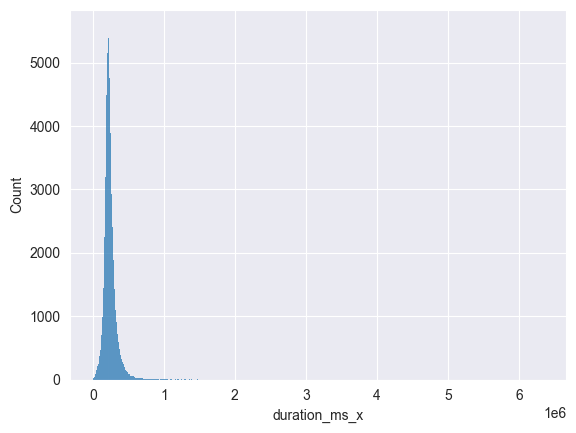

In [12]:
sns.histplot(df["duration_ms_x"])
plt.show()

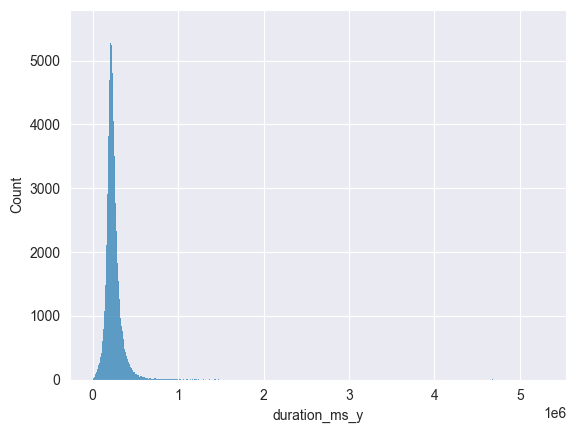

In [13]:
sns.histplot(df["duration_ms_y"])
plt.show()

In [14]:
print(f'{df[df["duration_ms_x"] != df["duration_ms_y"]].shape[0]/df.shape[0]*100//1}% of the tracks have different duration_ms_x than duration_ms_y')

37.0% of the tracks have different duration_ms_x than duration_ms_y


-> From looking at the documentation and the plots they are probably the duration from the track and the feature table, so none of them is more credible than the other, so we take the mean

In [15]:
df["duration"] = (df["duration_ms_y"] + df["duration_ms_x"]) / 2

Test if it is the mean

In [16]:
df[["duration_ms_x", "duration_ms_y", "duration"]].sample(10)

,duration_ms_x,duration_ms_y,duration
uri,,,
spotify:track:7iBUz5Dxu8mjZHeyu9dSBk,258680.0,258680.0,258680.0
spotify:track:4lcpWCMFXNhvqNIQhB6yDv,283760.0,283760.0,283760.0
spotify:track:6CVBgj7i7OFWaP9OLS61o2,211331.0,211332.0,211331.5
spotify:track:5meFvUFgfKFflzzdMEtQvG,392826.0,392827.0,392826.5
spotify:track:0RkPo8kozDmbRXcmqfzbM5,176133.0,176133.0,176133.0
spotify:track:7qGZS8xWA3dPgBb3X7Yipk,154466.0,154467.0,154466.5
spotify:track:4IL0N8bqHEvZUDMqeswRDZ,270493.0,270493.0,270493.0
spotify:track:6zo52JP3T62BJWN1Fd802D,364800.0,364800.0,364800.0
spotify:track:7jZcwGuURMuRrg9twMEg3P,400493.0,400493.0,400493.0


In [17]:
del df["duration_ms_y"]
del df["duration_ms_x"]

#### See how many NaNs values each column has

In [18]:
for column in df:
    print(f"{column} has {round(df[column].isnull().sum()/df.shape[0]*100, 2)}% NaN values")

name has 0.01% NaN values
popularity has 0.01% NaN values
explicit has 0.01% NaN values
is_local has 0.01% NaN values
available_markets has 0.01% NaN values
preview_url has 50.93% NaN values
disc_number has 0.01% NaN values
track_number has 0.01% NaN values
artist has 39.21% NaN values
language has 40.57% NaN values
lyrics has 39.21% NaN values
acousticness has 0.0% NaN values
danceability has 0.0% NaN values
energy has 0.0% NaN values
instrumentalness has 0.0% NaN values
key has 0.0% NaN values
liveness has 0.0% NaN values
loudness has 0.0% NaN values
mode has 0.0% NaN values
speechiness has 0.0% NaN values
tempo has 0.0% NaN values
time_signature has 0.0% NaN values
valence has 0.0% NaN values
duration has 0.01% NaN values


-> Columns with high number of NaNs: preview_url, artist, language and lyrics

#### Fixing preview_url

There is no relevant information in the preview_url because the only information that could be useful is the ending (.de, .com,...) to see from which country the song is,
but this is already covered by available markets

In [19]:
del df["preview_url"]

#### Fixing language

In [20]:
print(f"{round(df['language'].isnull().sum()/df.shape[0]*100, 2)}% of the language entries are NaN.")

40.57% of the language entries are NaN.


#### Can we fill it up over the artist?

In [21]:
print(f'{round(df[df["language"].isna()]["artist"].isnull().sum()/df["language"].isnull().sum()*100, 2)}% of the rows with missing language have a missing artist value.')

96.65% of the rows with missing language have a missing artist value.


-> No, that won't be a solution

#### Can we fill it up over the language of the language of the name?

How many and what languages do we have?

In [22]:
languages = df["language"].unique()
print(f"There are {languages.shape[0]} unique languages in the language column.")
print("The Languages are: (language/number of tracks in this language)")
for language in languages:
    print(str(language) + ": " + str(df[df["language"] == language].shape[0]), end=" ")

There are 50 unique languages in the language column.
The Languages are: (language/number of tracks in this language)
nan: 0 en: 163995 ja: 74 pt: 909 None: 0 es: 11155 fil: 379 fr: 836 it: 338 fi: 36 de: 376 ko: 417 is: 39 tr: 123 da: 28 sv: 148 no: 19 uk: 1 hi: 56 ar: 40 ru: 32 ta: 15 he: 41 pl: 18 gl: 1 id: 15 zh: 13 nl: 22 vi: 1 el: 24 fa: 13 la: 6 ro: 6 cy: 2 af: 7 ca: 7 ur: 1 sq: 3 pa: 3 te: 2 ceb: 1 bg: 2 eo: 1 ga: 6 hr: 1 eu: 1 lt: 1 hu: 2 gd: 1 sk: 1 

#### Check if we can use a language classification model to detect the language from the name

In [23]:
base_options = python.BaseOptions(model_asset_path="language_detector.tflite")
options = text.LanguageDetectorOptions(base_options=base_options)

In [24]:
with python.text.LanguageDetector.create_from_options(options) as detector:
    number_all = df[~df["language"].isnull()].shape[0]
    number_right_detected = 0
    number_not_detected = 0
    for index, row in df[~df["language"].isnull()].iterrows():
        detection_result = detector.detect(str(row["name"]))
        if len(detection_result.detections) > 0 and str(row["language"]) == str(detection_result.detections[0].language_code):
            number_right_detected += 1
        else:
            number_not_detected += 1
    print(f"Percentage of correct detected languages: {round(number_right_detected/number_all*100, 2)}% (Precision)")
    print(f"Percentage of not detected languages: {round(number_not_detected/number_all*100, 2)}%")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Percentage of correct detected languages: 85.65% (Precision)
Percentage of not detected languages: 14.35%


Yes, we can. The language classification model performs pretty well for our purposes

#### Using a language classification model to fill up the missing language data

In [25]:
with python.text.LanguageDetector.create_from_options(options) as detector:
    i = 0
    for index, row in df[df["language"].isnull()].iterrows():
        detection_result = detector.detect(str(row["name"]))
        if len(detection_result.detections) > 0:
            i += 1
            df.loc[index, "language"] = detection_result.detections[0].language_code
print(f"{df[df['language'].isnull()].shape[0]/ df.shape[0] * 100 // 1}% of the language values are still NaN.")

2.0% of the language values are still NaN.


-> There are no more ways to fill these missing values so we will drop the rows with missing language values

In [26]:
df.dropna(axis=0, subset=["language"], inplace=True)
print(f"{df[df['language'].isnull()].shape[0]} of the language values are still NaN.")

0 of the language values are still NaN.


#### Fixing artist

There is no way to fill the missing values, so we need to delete the entire column because 39% NaNs is very high

In [27]:
del df["artist"]

#### Fixing lyrics

There is no way to fill the missing values, so we need to delete the entire column because 39% NaNs is very high

In [28]:
del df["lyrics"]

#### Control if we handled all NaNs values

In [29]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()} NaN values")

name has 18 NaN values
popularity has 18 NaN values
explicit has 18 NaN values
is_local has 18 NaN values
available_markets has 18 NaN values
disc_number has 18 NaN values
track_number has 18 NaN values
language has 0 NaN values
acousticness has 1 NaN values
danceability has 1 NaN values
energy has 1 NaN values
instrumentalness has 1 NaN values
key has 1 NaN values
liveness has 1 NaN values
loudness has 1 NaN values
mode has 1 NaN values
speechiness has 1 NaN values
tempo has 1 NaN values
time_signature has 1 NaN values
valence has 1 NaN values
duration has 19 NaN values


-> There are still a few NaN values but so few that we can just delete the regarding rows

In [30]:
df.dropna(inplace=True)

In [31]:
for column in df:
    print(f"{column} has {df[column].isnull().sum()} NaN values")

name has 0 NaN values
popularity has 0 NaN values
explicit has 0 NaN values
is_local has 0 NaN values
available_markets has 0 NaN values
disc_number has 0 NaN values
track_number has 0 NaN values
language has 0 NaN values
acousticness has 0 NaN values
danceability has 0 NaN values
energy has 0 NaN values
instrumentalness has 0 NaN values
key has 0 NaN values
liveness has 0 NaN values
loudness has 0 NaN values
mode has 0 NaN values
speechiness has 0 NaN values
tempo has 0 NaN values
time_signature has 0 NaN values
valence has 0 NaN values
duration has 0 NaN values


-> We handled all missing values

#### Saving the DataFrame to save time

In [32]:
df.to_csv("df.csv")

In [33]:
df = pd.read_csv("df.csv")
df.set_index("uri", inplace=True)
print(df.shape)
df.head()

(294932, 21)


,name,popularity,explicit,is_local,available_markets,disc_number,track_number,language,acousticness,danceability,...,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:0ltRc18CGfqQXVoh9HmJEU,There'll Come A Day,33.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,5.0,en,0.000277,0.356,...,0.000000,4.0,0.193,-4.046,1.0,0.0411,159.017,4.0,0.353,203213.0
spotify:track:6ZOPMDgEU9gPg0gtlgTc3E,Alive,17.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,1.0,en,0.204000,0.503,...,0.000000,8.0,0.168,-4.448,0.0,0.0837,127.901,4.0,0.221,193125.0
spotify:track:28Wu2b54s7TPn0o8xSteeQ,Kill Em With Kindness - Felix Cartal Remix,0.0,0.0,0.0,NaN,1.0,1.0,en,0.004040,0.679,...,0.000005,10.0,0.253,-2.886,0.0,0.0365,121.970,4.0,0.503,196293.0
spotify:track:20wgVaEsW9ElKWEZkZYOrm,Te Vas,0.0,0.0,0.0,NaN,1.0,10.0,es,0.132000,0.830,...,0.000000,5.0,0.175,-7.995,0.0,0.1090,90.043,4.0,0.492,169346.5
spotify:track:4AZlgqkThHYfPSstdVuy2f,Goin' Back Down,0.0,0.0,0.0,NaN,1.0,3.0,en,0.054200,0.518,...,0.000013,10.0,0.307,-4.924,0.0,0.1060,170.211,4.0,0.632,225740.0


#### Transform available_markets and language to numerical values

Save information about the most popular languages for later

In [34]:
language_count = df.groupby("language").count()["name"].sort_values(ascending=False)

Check how many unique values there are to decide if we use one-hot-encoding or integer coding

In [35]:
print(f"There are {df['language'].unique().shape[0]} unique languages.")

There are 100 unique languages.


-> We would about 6x the amount of features with one-hot-encoding => Integer Coding

In [36]:
df.language = df.language.astype("category").cat.codes

Test if integer coding was successful

In [37]:
print(f"There are {df['language'].unique().shape[0]} different codes")
df["language"].sample(10)

There are 100 different codes


uri
spotify:track:16i6f7yJWs1j67fxBjfc7z    17
spotify:track:6XiPegr4iaqnj6GCpI5zA3    17
spotify:track:7KjlbXAcL3tXKOiHpl6jxO    17
spotify:track:1WUopg55mBbofkfQz5xOIF     3
spotify:track:0iKBQiTlNxTUPeBDCzlFRP    17
spotify:track:6iXo7ISHkEoRaQ1zLZEvPS    17
spotify:track:1hbFcQwjoM49u8c8UhyBcJ    17
spotify:track:742gr3gvl0Iir8BFboSzWX    17
spotify:track:4KVutc1EskcnC4JMCATtMp    17
spotify:track:11sV5RZfZ4FEKz0TeFnvN6    17
Name: language, dtype: int8

-> 100 codes for 100 different languages

In [38]:
countries = set()
for index, row in df.iterrows():
    countries.update(set(str(row["available_markets"]).replace(" ", "").split(",")))
print(countries)
print(f"There are {len(countries)} different markets.")

{'FI', 'VE', 'TV', 'LI', 'PT', 'JP', 'SR', 'CO', 'TZ', 'UG', 'ML', 'MN', 'GR', 'ZA', 'JM', 'DJ', 'IL', 'MH', 'IS', 'NE', 'BW', 'BJ', 'FJ', 'NO', 'ST', 'WS', 'BA', 'NA', 'QA', 'BG', 'CG', 'MD', 'NP', 'AU', 'CD', 'TN', 'CZ', 'FR', 'SV', 'MC', 'TD', 'ME', 'MY', 'AR', 'CA', 'KN', 'EC', 'SA', 'BB', 'IQ', 'IE', 'KH', 'MV', 'CI', 'CM', 'MG', 'GT', 'DZ', 'ID', 'CV', 'VN', 'LT', 'KZ', 'MT', 'UY', 'PE', 'ZM', 'BN', 'LV', 'PG', 'HK', 'BF', 'KG', 'HU', 'LS', 'OM', 'DK', 'TT', 'GD', 'UZ', 'CR', 'TJ', 'ET', 'AT', 'SK', 'GB', 'GY', 'IN', 'IT', 'KE', 'LB', 'TL', 'JO', 'HR', 'MA', 'LY', 'AL', 'BS', 'PY', 'PH', 'nan', 'LA', 'BD', 'GA', 'CL', 'SL', 'VC', 'PL', 'NZ', 'BE', 'AG', 'KW', 'EG', 'RS', 'BI', 'TR', 'GE', 'SG', 'HN', 'TH', 'PS', 'SM', 'MO', 'DM', 'VU', 'US', 'SE', 'SB', 'HT', 'FM', 'MW', 'BR', 'NL', 'LK', 'MK', 'BY', 'CH', 'LR', 'CW', 'MZ', 'GQ', 'BT', 'NR', 'GW', 'BZ', 'CY', 'NI', 'SC', 'SZ', 'GH', 'TW', 'LU', 'KI', 'BO', 'NG', 'PK', 'MU', 'TG', 'DE', 'GN', 'BH', 'AM', 'SN', 'KR', 'LC', 'EE', 'D

-> 184 markets ("" is no market)are way too much for one-hot-encoding (around 10x the amount of features) and integer coding is not an option because there are often multiple markets in one row

Further information: The official number of markets for spotify is also 184

#### => Translate the markets in possible hearers (size of country)

-> Are there markets in which all tracks are available?

In [39]:
cut_countries = set()
for index, row in df.iterrows():
    cut_countries = set.intersection(set(str(row["available_markets"]).replace(" ", "").split(",")), cut_countries)
print(f"In {len(cut_countries)} markets every track is available.")

In 0 markets every track is available.


-> No so all are relevant
But there is no specific data about the users per market, only per continent so it is pretty hard to get the number of possible hearers
=> We will just use the number of available markets

In [40]:
for index, row in df.iterrows():
    df.loc[index, "number_availabe_markets"] = len(set(str(row["available_markets"]).replace(" ", "").split(",")))
df.sample(10)

,name,popularity,explicit,is_local,available_markets,disc_number,track_number,language,acousticness,danceability,...,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:2uMVuuPuX0dhHyc2L4U8OE,Control,8.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CL, CO, CY, CZ, DK...",1.0,11.0,17,0.819000,0.364,...,4.0,0.1140,-9.400,0.0,0.0724,111.882,4.0,0.2070,300231.5,161.0
spotify:track:2TzznDI3V0411fk2Glxg2B,Que Me Perdone Dios,2.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,3.0,69,0.115000,0.413,...,0.0,0.5720,-10.566,1.0,0.0510,181.717,3.0,0.4930,158746.5,184.0
spotify:track:0ra9gcHz17v53ex6srg1Ew,The End - WRLD Remix,24.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,5.0,17,0.294000,0.586,...,11.0,0.1850,-4.213,0.0,0.0562,157.005,4.0,0.3120,211500.0,181.0
spotify:track:5KhE6I6StxZ4Rh5MMkDbNx,One Night Stand,0.0,0.0,0.0,NaN,1.0,3.0,17,0.002560,0.398,...,2.0,0.1290,-3.491,1.0,0.0389,109.892,4.0,0.7450,168027.5,1.0
spotify:track:5UiT4e4DHwZrcVIXojU5um,Surprise Party (feat. Blackbear),59.0,1.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,6.0,17,0.004530,0.671,...,6.0,0.1730,-4.224,0.0,0.0647,72.946,4.0,0.3790,188039.5,184.0
spotify:track:0Yc7jkGjYSQc1x2G2oVG5H,Sumérgeme en Tu Gloria (En Vivo),0.0,0.0,0.0,NaN,1.0,6.0,19,0.678000,0.359,...,2.0,0.8290,-6.644,1.0,0.0374,139.941,4.0,0.2640,289970.5,1.0
spotify:track:73zF5ir91Qk75QkgxNELeU,Al Partir,33.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,10.0,19,0.038500,0.618,...,7.0,0.2440,-7.280,1.0,0.0585,101.952,4.0,0.6830,192426.5,183.0
spotify:track:1TO7Af9aTlRP8aIHJzOsfW,Mass Extinction Six,0.0,0.0,0.0,NaN,1.0,4.0,17,0.000212,0.427,...,1.0,0.0841,-3.561,0.0,0.2650,150.002,4.0,0.0643,293973.0,1.0
spotify:track:3aS1XMxh9Wap72VMav7zOn,Islands,14.0,0.0,0.0,"AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY...",1.0,3.0,17,0.066600,0.502,...,11.0,0.1020,-5.503,0.0,0.0320,139.954,4.0,0.7090,210520.0,184.0


In [41]:
del df["available_markets"]

#### In the documentation stands that tracks will be listed seperated for the single and album version even if they are the same
The URI is also different if the track is a single or in a different album even though it is the same track

In [42]:
print(f"There are {df['name'].nunique()} unique names but overall {df.shape[0]} tracks listed.")

There are 223193 unique names but overall 294932 tracks listed.


#### Merging rows together which refer to the same track
We will use the language, explicit and key features to check if it really the same track because these are most resistant to measurement errors.
Because the formula of the popularity index is unknown, we can not use the sum of both or something like that without risking to hurt the data quality, so we will use the max value.
For available markets and is_local we will also use the max value, for the rest the mean value

In [43]:
aggregate_function = {"popularity": "max", "is_local": "max", "disc_number": "mean", "track_number": "mean", "acousticness": "mean", "danceability": "mean", "energy": "mean", "instrumentalness": "mean", "liveness": "mean", "loudness": "mean", "mode": "mean", "speechiness":"mean", "tempo":"mean", "time_signature": "mean", "valence": "mean", "duration":"mean", "number_availabe_markets": "max", "uri": "first"}
reindexed_df = df.reset_index()
agg_df = reindexed_df.groupby(["name", "language", "explicit", "key"], as_index=True).aggregate(aggregate_function).reset_index()
agg_df.set_index("uri", inplace=True)

In [44]:
# test
print(df.shape, agg_df.shape)
agg_df.head(10)

(294932, 21) (271973, 21)


,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:1BOYYOtxjA57QUmNwc1yyv,!Dios Mio! El Diablo Es Muy Picante,19,0.0,9.0,2.0,0.0,1.0,1.0,0.880000,0.308,...,0.850,0.4090,-11.463,0.0,0.0402,68.114,4.0,0.0338,125702.0,184.0
spotify:track:6hcxMbNQOOY6mdDpTzxecw,!Me Voy Pal' Pueblo - Live,19,0.0,10.0,20.0,0.0,1.0,7.0,0.512000,0.812,...,0.545,0.1030,-4.605,0.0,0.1550,136.317,4.0,0.8140,267840.0,70.0
spotify:track:0OXFi5JzxBHYcEWEJ1I79f,""" Frühlingssinfonie "" , Sinfonie Nr. 1, B-Dur,...",13,0.0,10.0,6.0,0.0,1.0,6.0,0.974000,0.312,...,0.909,0.0715,-16.622,1.0,0.0360,130.026,4.0,0.0780,698160.0,184.0
spotify:track:5ekAAj9FA91U5aXFQQHMoz,"""*!*!"" What U Heard",17,1.0,2.0,20.0,0.0,1.0,6.0,0.082100,0.821,...,0.000,0.0829,-9.096,0.0,0.1370,104.459,4.0,0.7400,197466.5,182.0
spotify:track:01KHK7KB8elDN6owqYqNmV,"""2014: A Pesach Medley""",82,0.0,6.0,3.0,0.0,1.0,1.0,0.451000,0.425,...,0.000,0.3710,-7.925,0.0,0.1040,86.088,4.0,0.4980,321637.0,184.0
spotify:track:54Lm6t48g3nG1NYmBVKCnA,"""40"" - Remastered 2008",17,0.0,8.0,0.0,0.0,1.0,10.0,0.185000,0.371,...,0.582,0.1830,-9.315,1.0,0.0307,150.316,4.0,0.3100,157666.5,1.0
spotify:track:25Sd73fleKUVPNqITPZkn1,"""45""",48,0.0,8.0,51.0,0.0,1.0,1.0,0.000696,0.315,...,0.000,0.2770,-4.709,1.0,0.1020,178.068,4.0,0.4230,202493.0,2.0
spotify:track:44241N8eadh4VlJAd6kQnN,"""A Beautiful Mine"" - Theme from the Amc Series...",17,0.0,8.0,0.0,0.0,1.0,1.0,0.075800,0.669,...,0.969,0.1400,-14.394,1.0,0.0413,114.275,4.0,0.2520,37926.0,1.0
spotify:track:5NCiTuYKMKUZejhGKeZB1b,"""A Lovely Night""",17,0.0,7.0,0.0,0.0,1.0,17.0,0.829000,0.425,...,0.000,0.2720,-6.948,1.0,0.1960,202.359,4.0,0.6800,151613.0,1.0


Why is the name column in many rows empty?

In [45]:
print(f"There are {df[df['name'] == ''].shape[1]} rows where name == ''.")

There are 21 rows where name == ''.


-> because there are many tracks with an empty name in the original df, so this not an error, the rest also seems fine, so we can save the changes

In [46]:
df = agg_df
print(f"We eliminated {294932-df.shape[0]} duplicates.")

We eliminated 22959 duplicates.


#### Checking if there are any range violations

In [47]:
df.describe()

,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
count,271973.000000,271973.000000,271973.000000,271973.000000,271973.0,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,271973.000000,2.719730e+05,271973.000000
mean,19.166325,0.129722,5.273189,17.581021,0.0,1.034362,6.093051,0.295846,0.565655,0.619007,0.143510,0.205242,-8.447121,0.656651,0.089572,120.925925,3.906743,0.472753,2.410034e+05,101.309351
std,10.307570,0.335998,3.568001,18.850626,0.0,0.330853,6.083880,0.320600,0.173829,0.243589,0.290474,0.179895,4.757033,0.470218,0.103894,29.097307,0.409100,0.254196,1.109797e+05,88.485756
min,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+03,1.000000
25%,17.000000,0.000000,2.000000,0.000000,0.0,1.000000,2.000000,0.020300,0.453000,0.456000,0.000000,0.097100,-10.221000,0.000000,0.035300,98.270000,4.000000,0.266000,1.920645e+05,1.000000
50%,17.000000,0.000000,5.000000,12.000000,0.0,1.000000,5.000000,0.154000,0.577000,0.656000,0.000084,0.130000,-7.256000,1.000000,0.048100,120.073000,4.000000,0.460000,2.259330e+05,170.000000
75%,17.000000,0.000000,8.000000,32.000000,0.0,1.000000,9.000000,0.530000,0.693000,0.818000,0.052900,0.259000,-5.323000,1.000000,0.091100,139.502000,4.000000,0.673000,2.693730e+05,184.000000
max,99.000000,1.000000,11.000000,91.000000,0.0,43.000000,167.000000,0.996000,0.991000,1.000000,1.000000,1.000000,3.744000,1.000000,0.965000,247.938000,5.000000,1.000000,5.279768e+06,184.000000


-> explicit is 0 or 1 (True or False), no violations

-> key is between 0 and 11 so according to the documentation there are no violations and the key was detected for all tracks

-> popularity is between 0 and 91 what is in the given spectrum of 0 to 100, so no violations

-> is_local is always 0 so always false due to the merging process, so also no violations

-> disc_number is at least 1 as given in the documentation, the max value has no limit since there could be an album with like 100 discs, so also no violations

-> track_number is at least 1 as given in the documentation, the max value has no limit since there could be an album with like 100 tracks, so also no violations

-> acousticness, danceability, energy, instrumentalness, liveness, mode, speechiness and valence reaches from 0 to (nearly) 1 as given in the documentation, so also no violations

-> loudness reaches from -60 (as given in the documentation) up to 3.744 instead of 0 => investigate why

-> tempo reaches from 0 to about 248, since there is no fix range given and 4 beats per seconds are reasonable probably no violations here

-> time_signature ranges from 0 to 5 and not as stated in the documentation from 3 to 7 => violations

-> duration ranges from 2s to 528s => 2s are very short, 528s very long investigate

-> number_available_markets reach from 1 to 184, since there needs to be at least one and can not be more than 184, since spotify only has 184 there are no violations

#### Investigate loudness

There are 95 tracks with loudness over 0.


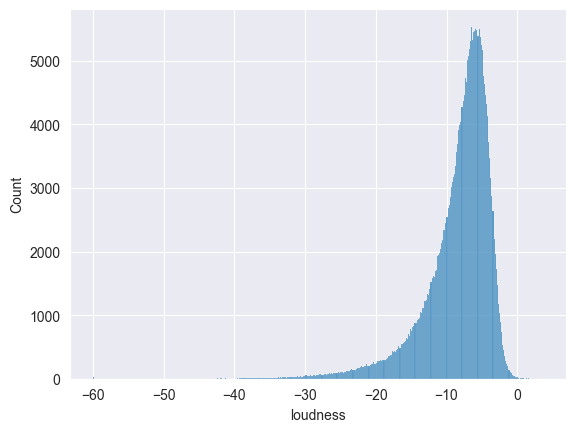

In [48]:
print(f"There are {df[df['loudness'] > 0].shape[0]} tracks with loudness over 0.")
sns.histplot(df["loudness"])
plt.show()

-> Since the loudness is in LUFS and LUFS can not be a positive number since for digital audio 0 is the maximum.
=> Delete rows with loudness over 0.

In [49]:
df = df[df['loudness'] <= 0]
print(f"There are {df[df['loudness'] > 0].shape[0]} tracks with loudness over 0.")

There are 0 tracks with loudness over 0.


#### Investigating time_signature

There are 2399 tracks with time_signature under 3.


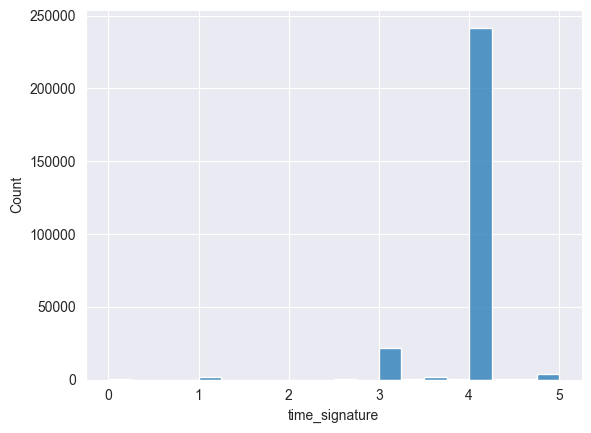

In [50]:
print(f"There are {df[df['time_signature'] < 3].shape[0]} tracks with time_signature under 3.")
sns.histplot(df["time_signature"])
plt.show()

In [51]:
df = df[df['time_signature'] >= 3]
print(f"There are {df[df['time_signature'] < 3].shape[0]} tracks with time_signature under 3.")

There are 0 tracks with time_signature under 3.


#### Investigate duration

In [52]:
df["duration"].describe()

count    2.694790e+05
mean     2.413291e+05
std      1.105503e+05
min      1.500000e+04
25%      1.923595e+05
50%      2.260860e+05
75%      2.695200e+05
max      5.279768e+06
Name: duration, dtype: float64

-> The extreme minimum outliers are already deleted, now the minimum duration is 15 seconds instead of 2s
-> 5270s could be something like a classical song or a mix

In [53]:
df[df["duration"] > 4e+06]

,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:5SBLB7hnQGD2pS6CGrpcA7,4x4=12 - Continuous Mix,17,0.0,1.0,0.0,0.0,2.0,1.0,0.000964,0.8090,...,0.199000,0.6210,-7.465,1.0,0.0744,128.065,4.0,0.10100,4195000.0,1.0
spotify:track:1BKPf8dLweDdB0KUAMwjOe,Back On Tracks - CD 1 FULL DJ MIX,17,0.0,7.0,4.0,0.0,1.0,31.0,0.003000,0.7170,...,0.747000,0.1840,-5.688,1.0,0.0614,126.056,4.0,0.24200,4382013.0,184.0
spotify:track:7J1fqAsqbmsWtY24mwNuMR,Back On Tracks 3 - Continuous Mix,17,0.0,1.0,2.0,0.0,1.0,30.0,0.000806,0.7240,...,0.764000,0.1710,-8.458,1.0,0.0588,124.998,4.0,0.28800,4512403.5,184.0
spotify:track:2zu9vmDJVHjYgPRdnFMB9I,Back On Tracks Vol 2 - MIXED CD,17,0.0,7.0,2.0,0.0,1.0,28.0,0.002010,0.7290,...,0.510000,0.8920,-8.620,1.0,0.0526,125.172,4.0,0.40700,4014706.5,184.0
spotify:track:3tJHrKmx1nqvkr0okE1aF5,Balearica 2016 - Chus & Ceballos Mixtape,14,0.0,11.0,13.0,0.0,1.0,25.0,0.004620,0.7280,...,0.803000,0.0902,-7.988,0.0,0.0419,124.050,4.0,0.25500,4355573.5,184.0
spotify:track:6poinNE1MAGvVqEWZEpzye,Blue Marlin Ibiza - Continuous DJ Mix 1,25,0.0,5.0,0.0,0.0,1.0,25.0,0.003640,0.7760,...,0.688000,0.0684,-8.833,0.0,0.0389,123.361,4.0,0.32200,4436000.0,1.0
spotify:track:6XMPs1OglOGSO4tTyEXvhc,Blue Marlin Ibiza - Continuous DJ Mix 2,25,0.0,8.0,0.0,0.0,1.0,26.0,0.019700,0.5390,...,0.483000,0.1410,-7.921,1.0,0.0412,114.740,4.0,0.26200,4316154.5,1.0
spotify:track:6SVEfC03iZiQRulq5Br9mA,Bonobo Late Night Tales Continuous Mix,17,0.0,4.0,0.0,0.0,1.0,1.0,0.529000,0.4070,...,0.097700,0.1990,-11.504,0.0,0.1660,77.929,4.0,0.07830,4497994.0,1.0
spotify:track:6RG1KXreBmvT4P38rLl9Sz,Club Life: Miami - Continuous DJ Mix,17,0.0,11.0,0.0,0.0,1.0,16.0,0.001750,0.6110,...,0.177000,0.0731,-5.644,0.0,0.0478,127.996,4.0,0.16200,4471884.5,1.0


-> mostly mixes and a couple of nature sounds and classical tracks so no violations

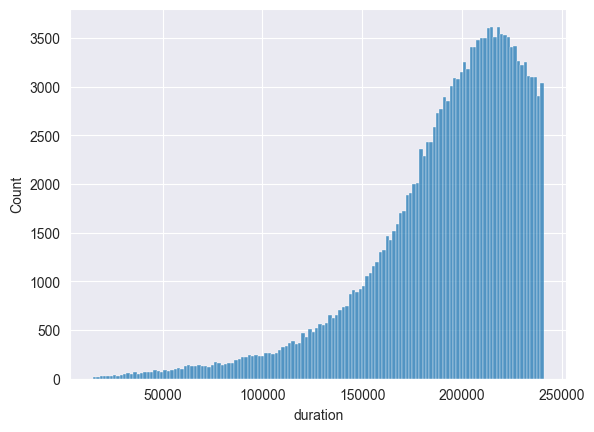

In [54]:
sns.histplot(df[df["duration"] < 2.41e+05]["duration"])
plt.show()

In [55]:
df[df["duration"] < 3e+04].sample(10)

,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:1oBECT3z0l4yfVnUjzen8M,Built This Pool,17,0.0,4.0,5.0,0.0,1.0,6.0,0.01730,0.536,...,0.000374,0.235,-2.683,1.0,0.1310,159.501,4.0,0.0000,16666.5,182.0
spotify:track:5zgH7ZQcF3c15Uy1JnH4dt,Elephant Parade,17,0.0,6.0,0.0,0.0,1.0,26.0,0.94300,0.466,...,0.850000,0.114,-24.323,0.0,0.0413,138.908,4.0,0.3970,26306.5,1.0
spotify:track:22mF9GxC4pPs7HY0toyHYy,Dogtown,17,1.0,4.0,0.0,0.0,1.0,8.0,0.67900,0.590,...,0.005300,0.199,-16.216,0.0,0.5380,53.354,4.0,0.0312,26801.5,137.0
spotify:track:4uMhAVYx5R4SvILLWR1Y0J,Georgia Fanfare,42,0.0,5.0,0.0,0.0,1.0,1.0,0.41500,0.217,...,0.940000,0.776,-10.175,1.0,0.0467,182.332,3.0,0.7130,23200.0,184.0
spotify:track:7e9PTsLobfB3hZNAbej5dc,"Monologue - Cafe Days - Live at Sin-é, New Yor...",17,0.0,11.0,0.0,0.0,1.0,13.0,0.55700,0.436,...,0.000207,0.146,-25.184,1.0,0.3690,114.691,4.0,0.0933,15000.0,184.0
spotify:track:2SlZLQTRyq0YMxhHqHIUwx,I Saw Drones,17,0.0,2.0,0.0,0.0,1.0,15.0,0.97000,0.419,...,0.935000,0.475,-25.567,1.0,0.0433,112.607,4.0,0.8070,27186.5,1.0
spotify:track:0NlYdi5fT2nvtGQWHX5h3I,Purgatory,17,1.0,7.0,0.0,0.0,1.0,11.0,0.21100,0.419,...,0.013800,0.123,-22.097,1.0,0.1500,87.855,4.0,0.2660,21040.0,184.0
spotify:track:6er8fQ2KPlaNihveqOXL6z,Lulu Intro - BBC Sessions,17,0.0,2.0,0.0,0.0,2.0,17.0,0.07070,0.763,...,0.000000,0.756,-13.492,1.0,0.5020,102.336,3.0,0.9700,22653.0,184.0
spotify:track:7AKz0918FbEZOABkxEalur,Addams Family Theme,17,0.0,0.0,4.0,0.0,1.0,1.0,0.00815,0.880,...,0.683000,0.215,-14.421,1.0,0.0663,62.440,4.0,0.0000,16239.5,183.0


-> Looked the tracks up on spotify and most of them really are that short so no violations

In [56]:
df.to_csv("df2.csv")

In [57]:
df = pd.read_csv("df2.csv")
df.set_index("uri", inplace=True)
print(df.shape)
df.head()

(269479, 21)


,name,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,...,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
uri,,,,,,,,,,,,,,,,,,,,,
spotify:track:1BOYYOtxjA57QUmNwc1yyv,!Dios Mio! El Diablo Es Muy Picante,19,0.0,9.0,2.0,0.0,1.0,1.0,0.8800,0.308,...,0.850,0.4090,-11.463,0.0,0.0402,68.114,4.0,0.0338,125702.0,184.0
spotify:track:6hcxMbNQOOY6mdDpTzxecw,!Me Voy Pal' Pueblo - Live,19,0.0,10.0,20.0,0.0,1.0,7.0,0.5120,0.812,...,0.545,0.1030,-4.605,0.0,0.1550,136.317,4.0,0.8140,267840.0,70.0
spotify:track:0OXFi5JzxBHYcEWEJ1I79f,""" Frühlingssinfonie "" , Sinfonie Nr. 1, B-Dur,...",13,0.0,10.0,6.0,0.0,1.0,6.0,0.9740,0.312,...,0.909,0.0715,-16.622,1.0,0.0360,130.026,4.0,0.0780,698160.0,184.0
spotify:track:5ekAAj9FA91U5aXFQQHMoz,"""*!*!"" What U Heard",17,1.0,2.0,20.0,0.0,1.0,6.0,0.0821,0.821,...,0.000,0.0829,-9.096,0.0,0.1370,104.459,4.0,0.7400,197466.5,182.0
spotify:track:01KHK7KB8elDN6owqYqNmV,"""2014: A Pesach Medley""",82,0.0,6.0,3.0,0.0,1.0,1.0,0.4510,0.425,...,0.000,0.3710,-7.925,0.0,0.1040,86.088,4.0,0.4980,321637.0,184.0


#### Investigating the unbalance in language (There are some languages in which basically no tracks are written and some in which many are written)

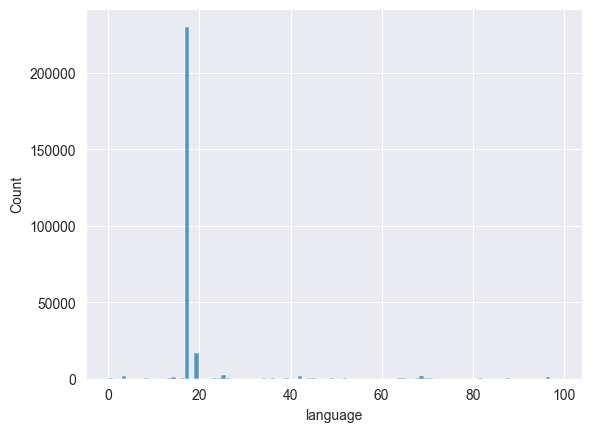

In [58]:
sns.histplot(df["language"], bins=100)
plt.show()

In [59]:
language_count.head()

language
en         253529
es          18010
fr           2854
ar-Latn      2156
it           2132
Name: name, dtype: int64

In [60]:
count_languages = defaultdict(int)
for index, row in df.iterrows():
    count_languages[int(row["language"])] += 1
print(count_languages)
print(f"{round(count_languages[17]/df.shape[0]*100, 2)}% of the tracks are in english.")
print(f"{round(count_languages[19]/df.shape[0]*100, 2)}% of the tracks are in spanish.")

defaultdict(<class 'int'>, {19: 17094, 13: 505, 17: 230072, 82: 568, 48: 141, 3: 2088, 88: 359, 64: 462, 42: 1989, 93: 76, 12: 120, 4: 7, 85: 18, 25: 2752, 65: 361, 1: 66, 36: 233, 26: 238, 31: 111, 8: 309, 30: 54, 0: 163, 34: 697, 70: 628, 54: 57, 52: 673, 39: 279, 69: 1722, 14: 1226, 60: 134, 45: 259, 97: 830, 23: 258, 38: 117, 49: 562, 29: 118, 20: 75, 71: 197, 7: 96, 11: 66, 37: 79, 68: 291, 24: 471, 66: 32, 16: 229, 56: 99, 90: 56, 40: 35, 77: 102, 46: 94, 33: 53, 84: 15, 10: 48, 41: 118, 99: 68, 18: 104, 27: 71, 76: 49, 32: 41, 78: 121, 2: 57, 15: 31, 28: 66, 44: 273, 81: 48, 98: 74, 21: 74, 83: 56, 57: 89, 61: 59, 72: 130, 74: 36, 75: 18, 73: 62, 9: 55, 22: 12, 50: 23, 92: 69, 55: 39, 80: 8, 53: 55, 6: 28, 94: 9, 96: 17, 35: 10, 95: 5, 67: 3, 89: 18, 79: 16, 91: 1, 51: 5, 86: 3, 5: 5, 58: 4, 47: 2, 59: 1, 43: 49, 87: 11, 62: 1, 63: 1})
85.38% of the tracks are in english.
6.34% of the tracks are in spanish.


=> Undersampling for 17 and 19, oversampling for some with very low representation?

-> data of other platforms like Apple Music, Amazon Music and YouTube shows that they also have mostly english tracks followed by spanish, so there is no bias we need to fix.
(source: https://f.hubspotusercontent10.net/hubfs/3796264/Blokur%202020%20Songwriters%20Review.pdf -> 20% none english is close to our about 15%)

#### Removing name
-> name is not a numerical value, using one-hot-encoding or integer coding is useless because most names are unique and provide no further information, information such as language, danceability etc. which we could get out of the name are already there

In [62]:
del df["name"]

#### Looking at the scatter plots to see if there are non linear correlations

In [ ]:
# Warning: needs very long to process
sns.pairplot(df)
plt.show()

In [64]:
df.columns

Index(['language', 'explicit', 'key', 'popularity', 'is_local', 'disc_number',
       'track_number', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
       'tempo', 'time_signature', 'valence', 'duration',
       'number_availabe_markets'],
      dtype='object')

-> speechiness and duration, track_number and speechiness, track_number and duration,

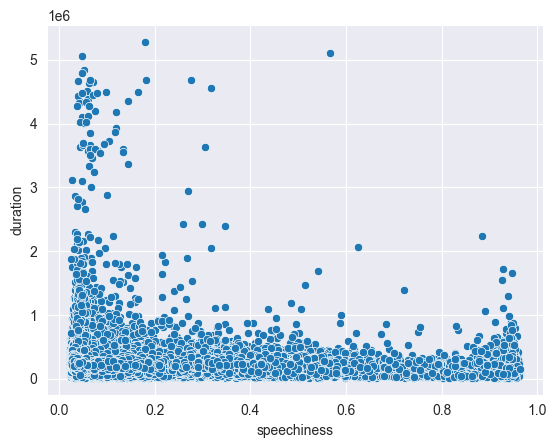

In [65]:
sns.scatterplot(data=df, x="speechiness", y="duration")
plt.show()

In [66]:
print(f"Original correlation: {df['duration'].corr(df['speechiness'])}")
print(f"Correlation with sqrt of speechiness: {df['duration'].corr(df['speechiness']**0.5)}")
print(f"Correlation with squared speechiness: {df['duration'].corr(df['speechiness']**2)}")

Original correlation: -0.05546095134150759
Correlation with sqrt of speechiness: -0.057253935520577344
Correlation with squared speechiness: -0.042097203369722204


-> Correlation is not better, so we won't add a polynomial feature

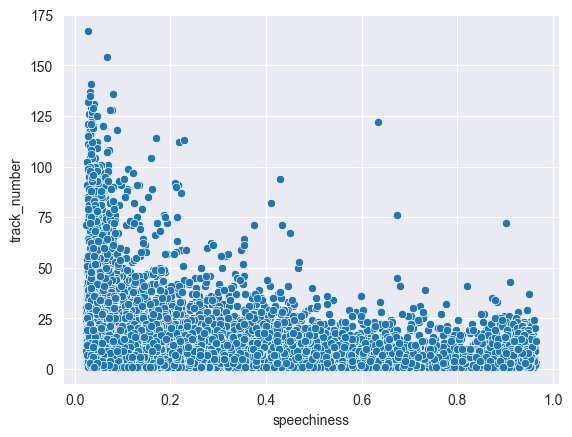

In [67]:
sns.scatterplot(data=df, x="speechiness", y="track_number")
plt.show()

In [68]:
print(f"Original correlation: {df['track_number'].corr(df['speechiness'])}")
print(f"Correlation with sqrt of speechiness: {df['track_number'].corr(df['speechiness']**0.5)}")
print(f"Correlation with squared speechiness: {df['track_number'].corr(df['speechiness']**2)}")

Original correlation: 0.026411483783792288
Correlation with sqrt of speechiness: 0.01745494069673585
Correlation with squared speechiness: 0.03605130170505532


-> Correlation is not significantly better, so we won't add a polynomial feature

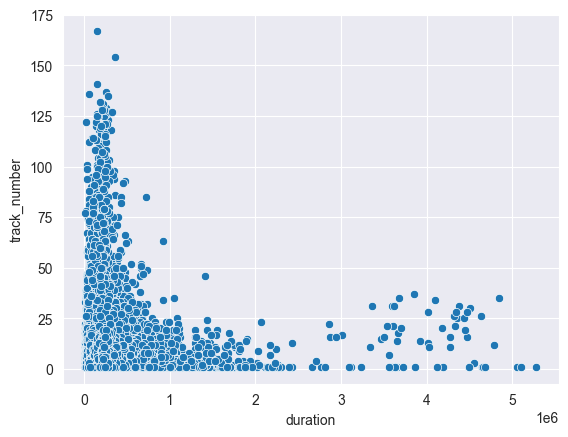

In [69]:
sns.scatterplot(data=df, x="duration", y="track_number")
plt.show()

In [70]:
print(f"Original correlation: {df['track_number'].corr(df['duration'])}")
print(f"Correlation with sqrt of duration: {df['track_number'].corr(df['duration']**0.5)}")
print(f"Correlation with squared duration: {df['track_number'].corr(df['duration']**2)}")

Original correlation: -0.02621816922275408
Correlation with sqrt of duration: -0.05315807096997319
Correlation with squared duration: 0.011369510984473424


-> Correlation is not significantly better, so we won't add a polynomial feature

#### Feature selection

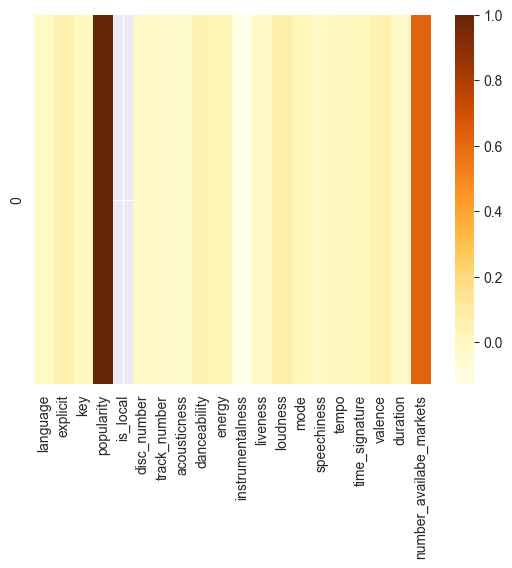

In [71]:
corrs = pd.DataFrame(columns=df.columns)
for column in df.columns:
    corrs[column] = [df["popularity"].corr(df[column])]
sns.heatmap(corrs, cmap="YlOrBr")
plt.show()

In [72]:
corrs.head()

,language,explicit,key,popularity,is_local,disc_number,track_number,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets
0,-0.017781,0.058441,-0.001461,1.0,NaN,-0.032028,-0.03133,-0.04847,0.0399,0.034366,-0.129324,-0.017035,0.068468,0.017722,-0.020058,0.005913,0.013445,0.058617,-0.027504,0.625953


-> Only number_available_markets has a significant correlation, try how bad r-squared is with all features

# Data Analysis

In [73]:
Y = df["popularity"]
X = df.drop(axis=1, columns=["popularity"])

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
Y_std = sc_y.fit_transform(np.array(Y).reshape(-1, 1)).flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)

print(f"r-squared with all features: {regr.score(X_test, Y_test)}")

r-squared with all features: 0.4139509075359631


#### Drop features with less than 0.01 correlation

In [74]:
X.drop(axis=1, columns=["key", "is_local", "tempo"], inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)
print(f"r-squared with features that have a correlation above 0.01: {regr.score(X_test, Y_test)}")

r-squared with features that have a correlation above 0.01: 0.41199422300275557


#### Only use number_available_markets and instrumentalness

In [75]:
X.drop(axis=1, columns=["language", "explicit", "disc_number", "track_number", "acousticness", "danceability", "energy", "liveness", "loudness", "mode", "speechiness", "time_signature", 'valence', "duration"], inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)

print(f"r-squared with only number_available_markets and instrumentalness: {regr.score(X_test, Y_test)}")

r-squared with only number_available_markets and instrumentalness: 0.40980690647958173


#### Only use number_available_markets

In [76]:
X.drop(axis=1, columns=["instrumentalness"], inplace=True)

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)

print(f"r-squared with only number_available_markets: {regr.score(X_test, Y_test)}")

r-squared with only number_available_markets: 0.4120487974405953


## First Conclusion
With only the track, feature and lyrics data we are not able to properly predict the popularity, the only feature with a high correlation is number_available_markets.
We will add the data from artist and check if we can than predict the popularity better.

# Adding artist data

In [77]:
print(f"There are {artist_df.shape[0]} artists in total, {artist_df['name'].unique().shape[0]} with unique names in artist_df.")
print(f"There are {lyrics_df['artist'].unique().shape[0]} artists with unique names in lyrics_df.")

There are 57141 artists in total, 56554 with unique names in artist_df.
There are 30406 artists with unique names in lyrics_df.


-> We have more than enough artists in artist_df. We will drop duplicates by deleting the less popular

#### Deleting duplicates in arist_df

In [78]:
artist_df.head()

,uri,type,name,genres,popularity,followers
0,spotify:artist:3ezgzYcj7p1GXXhHSCs7T3,artist,The EFFECTS,,3,755
1,spotify:artist:58HLYjCrUoNKPGD4IUqHhM,artist,Toito,,16,292
2,spotify:artist:48ghZ9vkjXWnq4ODIrqGGI,artist,Cherry Pie,,3,255
3,spotify:artist:1FfJF5xoAMmermBUVxoEYV,artist,"Manolín, El Médico De La Salsa","cubaton, timba",28,11436
4,spotify:artist:4gqouQdirzlMyGgnjMrrIU,artist,Marco Tegui,"electronica peruana, organic house",34,4594


type and uri delivers no information -> delete

In [79]:
del artist_df["type"]
del artist_df["uri"]

Checking genres

In [80]:
print(f"{round(artist_df['genres'].isnull().sum()/artist_df.shape[0]*100, 2)}% of the genre data is NaN.")
print(f"{round(artist_df[artist_df['genres']==''].shape[0]/artist_df.shape[0]*100, 2)}% of the genre data is empty.")

0.0% of the genre data is NaN.
33.8% of the genre data is empty.


-> There is no way to fill up the empty genre data -> delete

In [81]:
del artist_df["genres"]

Deleting duplicates

In [82]:
artist_aggregate_function = {"popularity": "max", "followers": "max"}
non_duplicate_artist_df = artist_df.groupby(by=["name"]).aggregate(artist_aggregate_function).reset_index()
print(f"The new DataFrame has {non_duplicate_artist_df.shape[0]} entries and there were {artist_df['name'].unique().shape[0]} artists with unique names")
non_duplicate_artist_df.head()

The new DataFrame has 56554 entries and there were 56554 artists with unique names


,name,popularity,followers
0,!!!,43,152471
1,!llmind,37,4508
2,"""Jesus Christ Superstar"" 1992 Australian Cast",19,2419
3,"""Killer"" Ray Appleton",0,8
4,"""Latin Pete"" Terrace and His Orchestra",6,34


In [83]:
artist_df = non_duplicate_artist_df
artist_df.set_index("name", inplace=True)

#### Adding artist names to df again
-> Since there is no way to fill the 39% NaN values for artist which exist because we have done a full outer join but the artist data is only given by the lyrics_df which has 39% less rows but 0 missing artist data. So we will do an inner join this time, and don't use the features_df since it doesnt have any features with high correlation to popularity.

In [84]:
# test
print(f'There are {lyrics_df["artist"].isnull().sum()} NaN entries for the artist column in features_df.')

There are 0 NaN entries for the artist column in features_df.


In [85]:
df = df.merge(lyrics_df[["uri", "artist"]], how="inner", on="uri")
df.shape

(165912, 22)

## Merging artist_df to df

In [86]:
df = df.merge(artist_df, how="inner", left_on="artist", right_on="name")
df.head()

,uri,language,explicit,key,popularity_x,is_local,disc_number,track_number,acousticness,danceability,...,mode,speechiness,tempo,time_signature,valence,duration,number_availabe_markets,artist,popularity_y,followers
0,spotify:track:0EGYtfb76OfLTJtFGwkGs2,17,1.0,1.0,0.0,0.0,1.0,1.0,0.84100,0.315,...,1.0,0.0532,192.002,5.0,0.3570,199520.5,1.0,Sofi de la Torre,39,37468
1,spotify:track:4laFlvKW29mVvlU7v9b1bf,17,0.0,11.0,0.0,0.0,1.0,4.0,0.06040,0.860,...,0.0,0.0731,119.995,4.0,0.0587,258638.0,1.0,Sofi de la Torre,39,37468
2,spotify:track:0b1UIUbOwe4tObMfbuonnW,17,0.0,6.0,0.0,0.0,1.0,1.0,0.00267,0.544,...,1.0,0.0500,172.093,4.0,0.1530,281860.0,1.0,Sofi de la Torre,39,37468
3,spotify:track:31k336IbmnyKcfRxdMYVRU,17,0.0,11.0,0.0,0.0,1.0,8.0,0.46900,0.610,...,1.0,0.1410,85.974,4.0,0.3050,195139.5,1.0,Sofi de la Torre,39,37468
4,spotify:track:3U1NVPoUjdSHRsU0e1c7t4,17,0.0,6.0,0.0,0.0,1.0,3.0,0.23700,0.638,...,0.0,0.0969,136.056,4.0,0.3060,196000.0,1.0,Sofi de la Torre,39,37468


-> Since there are now about 15,000 less rows there must have been artists in df which were not in artist_df but there is no way to fill the lacking information about these artists since we don't have the spotify artist id available

In [87]:
df.set_index("uri", inplace=True)

## Integer coding for artist

In [88]:
print(f"There are {df.artist.unique().shape[0]} unique artists in df. ")

There are 23420 unique artists in df. 


In [89]:
df.artist = df.artist.astype("category").cat.codes
print(f"There are {df.artist.unique().shape[0]} unique artist codes in df. ")

There are 23420 unique artist codes in df. 


# Dropping features with low correlation to popularity

In [90]:
df.drop(axis=1, inplace=True, columns=["language", "explicit", "key", "is_local", "disc_number", "track_number", "acousticness", "danceability", "energy",
                                       "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "valence", "duration"])
df.head()

,popularity_x,instrumentalness,number_availabe_markets,artist,popularity_y,followers
uri,,,,,,
spotify:track:0EGYtfb76OfLTJtFGwkGs2,0.0,0.000073,1.0,18500,39,37468
spotify:track:4laFlvKW29mVvlU7v9b1bf,0.0,0.003790,1.0,18500,39,37468
spotify:track:0b1UIUbOwe4tObMfbuonnW,0.0,0.030800,1.0,18500,39,37468
spotify:track:31k336IbmnyKcfRxdMYVRU,0.0,0.000003,1.0,18500,39,37468
spotify:track:3U1NVPoUjdSHRsU0e1c7t4,0.0,0.018600,1.0,18500,39,37468


In [91]:
df.rename(columns={"popularity_x": "track_popularity", "popularity_y": "artist_popularity", "artist": "artist"}, inplace=True) # renaming artist because the type of the column name is quoted_name and the scaler only accepts strings

-> We see that the first tracks have a 0 popularity but the artist have a 39 -> look at the artist popularity distribution

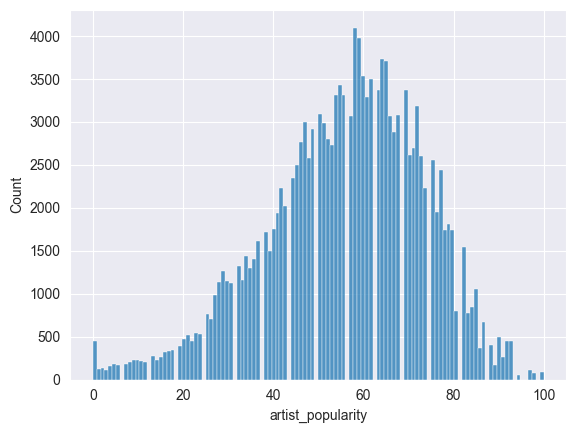

In [92]:
sns.histplot(df["artist_popularity"])
plt.show()

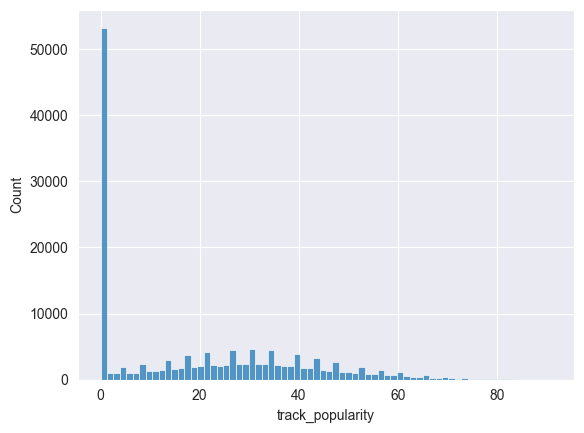

In [93]:
sns.histplot(df["track_popularity"])
plt.show()

-> The distribution of artist_popularity and track_popularity are very different => will the artist_popularity really help us to make better decisions?

## Feature selection

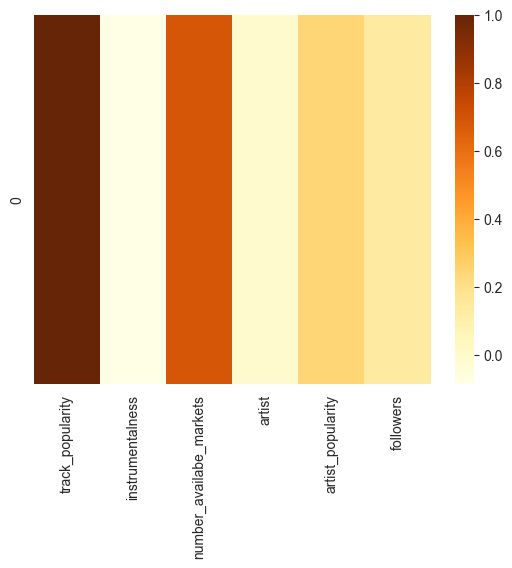

In [94]:
corrs2 = pd.DataFrame(columns=df.columns)
for column in df.columns:
    corrs2[column] = [df["track_popularity"].corr(df[column])]
sns.heatmap(corrs2, cmap="YlOrBr")
plt.show()

In [95]:
corrs2.head()

,track_popularity,instrumentalness,number_availabe_markets,artist,artist_popularity,followers
0,1.0,-0.086877,0.689705,-0.006764,0.244167,0.135813


-> We can drop artist, artist_popularity and followers also have low correlation

In [96]:
del df["artist"]

# Data Analysis

In [97]:
Y = df["track_popularity"]
X = df.drop(axis=1, columns=["track_popularity"])

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
Y_std = sc_y.fit_transform(np.array(Y).reshape(-1, 1)).flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)

print(f"r-squared with number_available_markets, instrumentalness and artist data: {regr.score(X_test, Y_test)}")

r-squared with number_available_markets, instrumentalness and artist data: 0.5408967970640105


#### Dropping followers

In [98]:
Y = df["track_popularity"]
X = df.drop(axis=1, columns=["track_popularity", "followers"])

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
Y_std = sc_y.fit_transform(np.array(Y).reshape(-1, 1)).flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)

print(f"r-squared with number_available_markets, instrumentalness and artist data without followers: {regr.score(X_test, Y_test)}")

r-squared with number_available_markets, instrumentalness and artist data without followers: 0.5300011097272642


## Dropping instrumentalness

In [99]:
Y = df["track_popularity"]
X = df.drop(axis=1, columns=["track_popularity", "followers", "instrumentalness"])

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
Y_std = sc_y.fit_transform(np.array(Y).reshape(-1, 1)).flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y_std, test_size=0.3)

lg = LinearRegression()
regr = lg.fit(X_train, Y_train)

print(f"r-squared with number_available_markets and artist data without followers: {regr.score(X_test, Y_test)}")

r-squared with number_available_markets and artist data without followers: 0.5344265290166801


# Conclusion

The best prediction we can make with the given data is by using the features number_available_markets, instrumentalness, artist_popularity and followers.
But instrumentalness and followers do not really change the outcome, so it is enough to just use number_available_markets and artist_popularity.
But even the prediction with these features is not good with an r-squared value of about 0.53, so we can only explain about 53% of the variability of the popularity.
So the most important factors are number_available_markets and artist_popularity. But the problem with number_available_markets is, that many popular tracks probably extend their available markets after getting popular. So the best overall feature to predict the future popularity is the popularity of the artist.